# 0. About

This notebook is to test out the construction of the pipeline, and to see if we chain everything correctly.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV

import pandas as pd
import seaborn as sns
from sklearn.datasets import make_regression
import scipy
import warnings

rs_num = 42
sklearn.set_config(display="diagram")

In [2]:
X, y = make_regression(
    n_samples=400, n_features=15, n_informative=3, 
    effective_rank=1, tail_strength=0.2, 
    n_targets=1, random_state=rs_num
)

[X_train, X_test, y_train, y_test] = train_test_split(X, y, random_state=rs_num)

# 1. Manually Put Everything Together

We can apply the following transformations:
1. Standardization
2. PCA with scree plot threshold, which requires a customized Transformer

For the estimator, we can use the Gaussian Process regression.

In [3]:
"""
Ref: 
1. For inherit the GPR class:
    https://stackoverflow.com/questions/62376164/
    how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
2. For modifiying the __init__:
    https://stackoverflow.com/questions/40025406/inherit-from-scikit-learns-lassocv-model
"""

class MyGPR(GaussianProcessRegressor):
    def __init__(
        self, 
        kernel=None, 
        *, 
        alpha=1e-10, 
        optimizer="fmin_l_bfgs_b", 
        n_restarts_optimizer=0, 
        normalize_y=False, 
        copy_X_train=True, 
        random_state=None, 
        max_iter=1e5, 
        **kwargs
    ):
        self.max_iter = max_iter
        super().__init__(
            kernel=kernel, 
            alpha=alpha, 
            optimizer=optimizer, 
            n_restarts_optimizer=n_restarts_optimizer, 
            normalize_y=normalize_y, 
            copy_X_train=copy_X_train, 
            random_state=random_state, 
            **kwargs
        )
    
    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func, 
                initial_theta, 
                method="L-BFGS-B", 
                jac=True, 
                bounds=bounds, 
                options={'maxiter': self.max_iter}
            )
            sklearn.utils.optimize._check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(
                obj_func, initial_theta, bounds=bounds
            )
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min


In [4]:
# standardization
manual_scaler = StandardScaler().fit(X_train)
X_train_scaled = manual_scaler.transform(X_train)
X_test_scaled = manual_scaler.transform(X_test)

# PCA
manual_pca = PCA(n_components=0.95).fit(X_train_scaled)
X_train_scaled_pca = manual_pca.transform(X_train_scaled)
X_test_scaled_pca = manual_pca.transform(X_test_scaled)

# GPR
manual_kernel = ConstantKernel(constant_value=1)*RBF(length_scale=1)
manual_gpr = MyGPR(
    kernel=manual_kernel, n_restarts_optimizer=9, random_state=rs_num
)
manual_gpr.fit(X_train_scaled_pca, y_train)

MyGPR(kernel=1**2 * RBF(length_scale=1), n_restarts_optimizer=9,
      random_state=42)

Now with everything ready, we can apply GPR repeated 5-fold cross-validation.

In [5]:
manual_gpr_scores_train = cross_validate(
    manual_gpr, X_train_scaled_pca, y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)

Also we can see how the models would behave over the test dataset.

In [6]:
manual_gpr_scores_test = manual_gpr.score(X_test_scaled_pca, y_test)

# 2. Chain Everything Together with Pipeline

In [7]:
gpr_pipeline = Pipeline(
    [('scaler', StandardScaler()), 
     ('pca', PCA(n_components=0.95, random_state=rs_num)), 
     ('gpr', 
      MyGPR(
          kernel=ConstantKernel(constant_value=1)*RBF(length_scale=1), 
          n_restarts_optimizer=9, 
          random_state=rs_num, 
          max_iter=1e5
      )
     )]
)
gpr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('gpr',
                 MyGPR(kernel=1**2 * RBF(length_scale=1),
                       n_restarts_optimizer=9, random_state=42))])

Now do the 5-fold cross-validation.

In [8]:
pipeline_scores_train = cross_validate(
    gpr_pipeline, X_train, y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)

Also we can see how the models would behave over the test dataset.

In [9]:
pipeline_scores_test = gpr_pipeline.score(X_test, y_test)

# 3. Compare Two Results

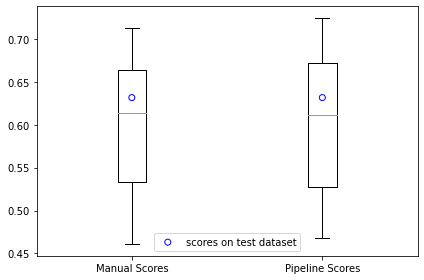

In [10]:
fig, ax = plt.subplots()

ax.boxplot(
    [manual_gpr_scores_train['test_score'], pipeline_scores_train['test_score']], 
    labels=['Manual Scores', 'Pipeline Scores']
)
ax.scatter(
    [1.0, 2.0], 
    [manual_gpr_scores_test, pipeline_scores_test], 
    fc='none',
    ec='blue', 
    label='scores on test dataset'
)

ax.legend(loc='lower center')
plt.tight_layout()

# 4. Use Pipeline with Grid Search

The idea is to use grid search method on the pipeline to find the best parameter for models.

In [11]:
# make an list for the possible component number we may try
component_num_list = [None, 0.99, 0.95, 0.90, 0.85, 0.80]

# make a list for the possible kernels we can use for GPR
kernel_list = [
    RBF(length_scale=1.0), 
    ConstantKernel(constant_value=1)*RBF(length_scale=1.0), 
    ConstantKernel(constant_value=1)*RBF(length_scale=1.0)+WhiteKernel()
]

In [12]:
# ignore warnings for some bad optimization
warnings.filterwarnings('ignore')

# construct pipeline
gpr_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('pca', PCA(random_state=rs_num)), 
        ('gpr', 
         MyGPR(
             random_state=rs_num, 
             max_iter=1e6
         )
        )
    ]
)

# define grid space
gpr_param_grid = [
    {
        'pca__n_components': component_num_list, 
        'gpr__kernel': kernel_list
    }
]

# construct grid search cv
gpr_gscv = GridSearchCV(
    gpr_pipeline, param_grid=gpr_param_grid, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)

# training and searching
gpr_gscv.fit(X_train, y_train)
print('Done')

# reset warnings
warnings.resetwarnings()

Done


In [13]:
cv_results_df = pd.DataFrame(gpr_gscv.cv_results_)

split_scores_arr = np.zeros((gpr_gscv.cv_results_['rank_test_score'].size, gpr_gscv.n_splits_))

for i_split in range(gpr_gscv.n_splits_):
    split_scores_arr[:, i_split] = gpr_gscv.cv_results_['split'+str(i_split)+'_test_score']

The best Grid No. selected is: 13
 ->> with estimator: 
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(random_state=42)),
                ('gpr',
                 MyGPR(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                       max_iter=1000000.0, random_state=42))])


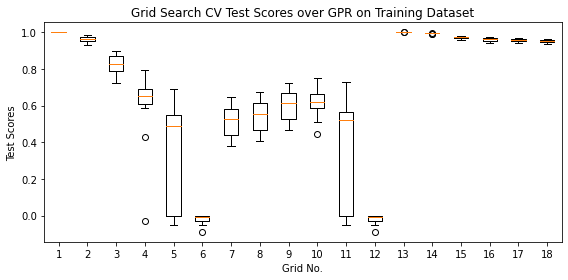

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.boxplot(split_scores_arr.T)

ax.set_title('Grid Search CV Test Scores over GPR on Training Dataset')
ax.set_ylabel('Test Scores')
ax.set_xlabel('Grid No.')

plt.tight_layout()

print('The best Grid No. selected is: '+str(gpr_gscv.best_index_+1))
print(' ->> with estimator: ')
print(gpr_gscv.best_estimator_)

# 5. Use the Best Estimator

In [17]:
warnings.filterwarnings('ignore')

best_pipeline = gpr_gscv.best_estimator_
best_pipeline.fit(X_train, y_train)

# also do cv
best_pipeline_scores_train = cross_validate(
    best_pipeline, X_train, y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)

# also see the performance on the test dataset
best_pipeline_scores_test = best_pipeline.score(X_test, y_test)

warnings.resetwarnings()

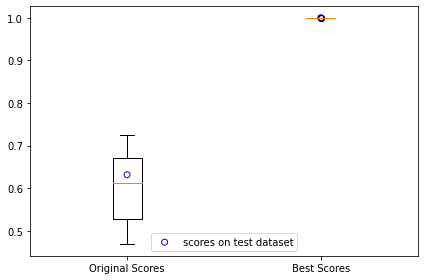

In [18]:
# visualization of the comparison
fig, ax = plt.subplots()

ax.boxplot(
    [pipeline_scores_train['test_score'], best_pipeline_scores_train['test_score']], 
    labels=['Original Scores', 'Best Scores']
)
ax.scatter(
    [1.0, 2.0], 
    [pipeline_scores_test, best_pipeline_scores_test], 
    fc='none',
    ec='blue', 
    label='scores on test dataset'
)

ax.legend(loc='lower center')
plt.tight_layout()